# RNAseq Analysis Using DESeq2

## Reformatting the Counts

DESeq2 is an R package that is widely used for differential expression analysis on transcriptomics data. 

Here, we first observe and reformat the text file that we constructed by counting reads per gene, to fit the analysis we will do by using R.

In [2]:
library("DESeq2")
library(scales)
options(repr.plot.width=4, repr.plot.height=3)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [3]:
matrixFile = path.expand("all.gene.counts")

In [4]:
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))
head(countData)

,control1.bam,control2.bam,mttl1.bam,mttl2.bam
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,9,5,11,0
RP11-34P13.8,0,0,0,0
AL627309.1,478,303,610,369


We will now check positive control genes of METTL14, which are target genes of METTL14:

CCND1 and SMAD3 seem to have a significant decrease in expression upon METTL14 Knockdown by siRNA, and YTHDF3 shows an increase in expression. Since YTHDF3 is blocked by METTL14, its absence should increase YTHDF3s expression.

In [6]:
countData['CCND1',]
countData['SMAD3',]
countData['YTHDF3',]

control1.bam control2.bam    mttl1.bam    mttl2.bam 
       17095        15110         7376         6709

control1.bam control2.bam    mttl1.bam    mttl2.bam 
       21603        20582        10078         9111

control1.bam control2.bam    mttl1.bam    mttl2.bam 
        3698         3517         6993         7077

In [7]:
colnames(countData) <- c("Control 1", "Control 2", "Mettl14-KD 1", "Mettl14-KD 2")
head(countData)

,Control 1,Control 2,Mettl14-KD 1,Mettl14-KD 2
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,9,5,11,0
RP11-34P13.8,0,0,0,0
AL627309.1,478,303,610,369


We can construct a barplot to see the amount of reads per sample:

Each sample seems to have approximately the same number of reads

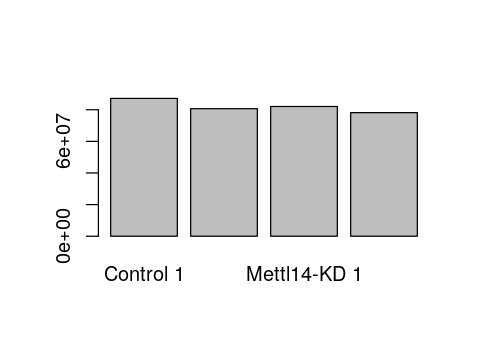

In [8]:
barplot(colSums(countData))

We then need to define the conditions for the analysis. Since the order of our countData is control, knockdown, we will also use this order when defining conditions. This means that the results we get (the log fold changes) will be in the format of Knockdown/Control. 

Thus, a positive log fold change will indicate upregulation in knockdown samples, while a negative log fold change will indicate downregulation in knockdown samples.

In [8]:
condition <- factor(c("control", "control", "M14_knockdown", "M14_knockdown"))
print(condition)

[1] control       control       M14_knockdown M14_knockdown
Levels: control M14_knockdown


In [9]:
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData

sampleName,condition
<fct>,<fct>
Control 1,control
Control 2,control
Mettl14-KD 1,M14_knockdown
Mettl14-KD 2,M14_knockdown


In [10]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
colnames(dds) <- colnames(countData)
dds
dds$condition

class: DESeqDataSet 
dim: 41863 4 
metadata(1): version
assays(1): counts
rownames(41863): MIR1302-11 FAM138A ... AC007965.1 RNU6-1314P
rowData names(0):
colnames(4): Control 1 Control 2 Mettl14-KD 1 Mettl14-KD 2
colData names(2): sampleName condition

[1] control       control       M14_knockdown M14_knockdown
Levels: control M14_knockdown

## Differential Expression Analysis

After reformatting the data to fit our analysis, it's now time to do the actual analysis. Here we will use one main function: DESeq function.

In [11]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Quality Control & Normalization

After the differential expression analysis, we need to do a quality control on the results to make sure we will get correct results, and correct/normalize for possible biases if they arise.

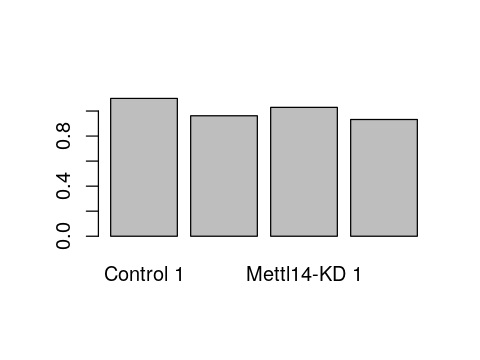

In [19]:
options(repr.plot.width=4, repr.plot.height=3)
barplot(sizeFactors(dds))

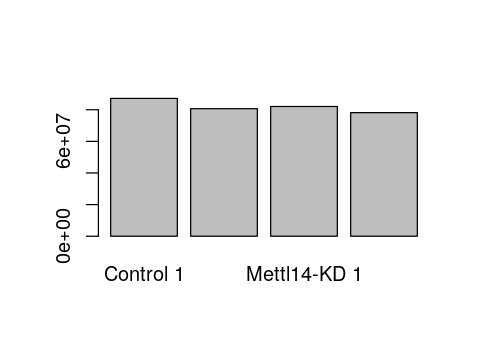

In [21]:
barplot(colSums(countData))

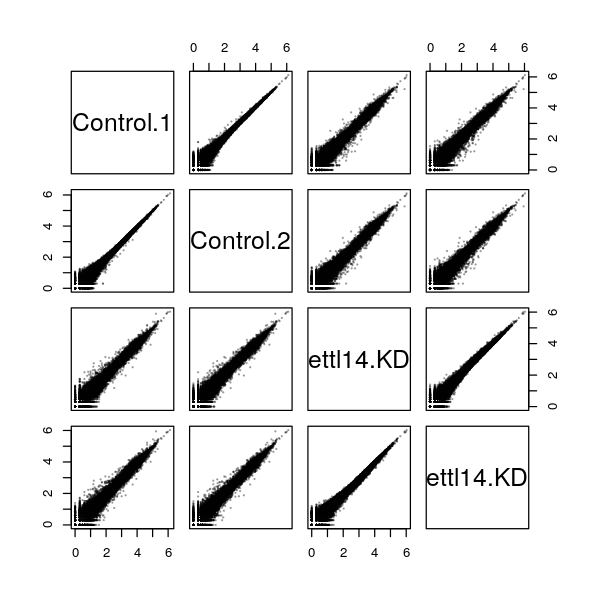

In [20]:
options(repr.plot.width=5, repr.plot.height=5)
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

### MA Plot

The MA Plot shows the mean expression (normalized) vs the log fold change. The red dots on the graph represent the differentially expressed genes in our dataset. 

Since as the read number goes down, the variance increases, we see a more wide black part than we see red.

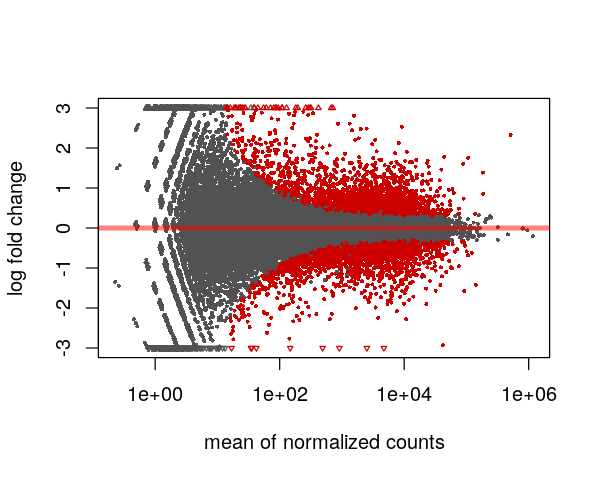

In [21]:
options(repr.plot.width=5, repr.plot.height=4)
plotMA(dds,ylim=c(-3,3))

## Exporting the Results

In [12]:
res <- results(dds)
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): condition M14 knockdown vs control 
Wald test p-value: condition M14 knockdown vs control 
DataFrame with 6 rows and 6 columns
                baseMean    log2FoldChange             lfcSE              stat
               <numeric>         <numeric>         <numeric>         <numeric>
METTL14 2513.40922921558 -3.73578792553621 0.169485526858298 -22.0419288583833
UCN2    909.924715343827 -4.32422613758515  0.20865220178185 -20.7245650928056
RHOB    4722.60285079881 -3.10927295949502 0.152892236089241 -20.3363691906512
TNFSF18 712.673729205223  3.88211593916872 0.215756435554037   17.993048175828
CALM2   41617.3704898716 -2.93235791753157 0.164204761136585 -17.8579347957666
DUSP1   9145.55505934299   2.5319937607002 0.149343436865701  16.9541682837869
                       pvalue                  padj
                    <numeric>             <numeric>
METTL14 1.14168520902456e-107 1.89439826733445e-103
UCN2     2.07998103085702e-95  1.72565626225052e-91
RHOB     

To find out how many genes are differentially expressed, we can easily count the ones that have a significant p-adjusted value. A significant p-adj value represents a significant log2 fold change.

In [13]:
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),]
dim(res.sign)

[1] 3319    6

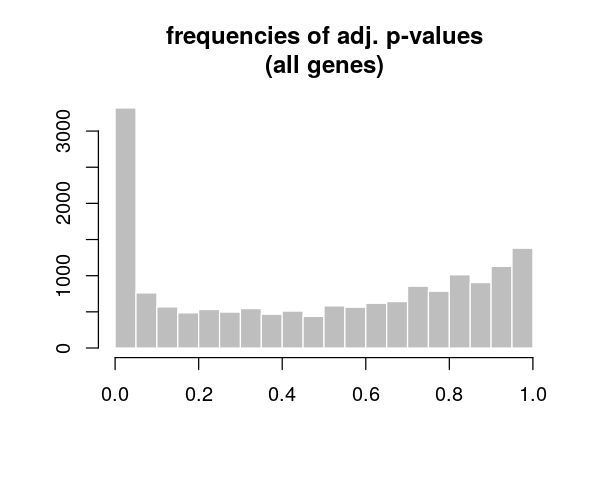

In [24]:
hist(res$padj, 
     col="grey", border="white", xlab="", ylab="", main="frequencies of adj. p-values\n(all genes)")

Below, we investigate the positive control genes and visualize their difference of expression in a scatter and barplot

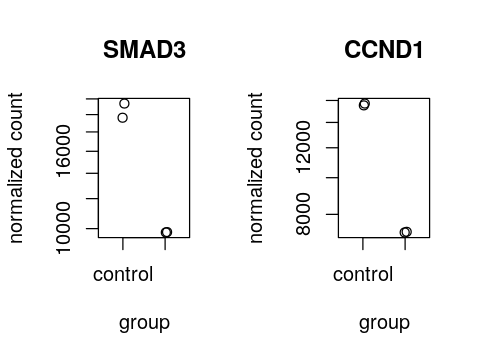

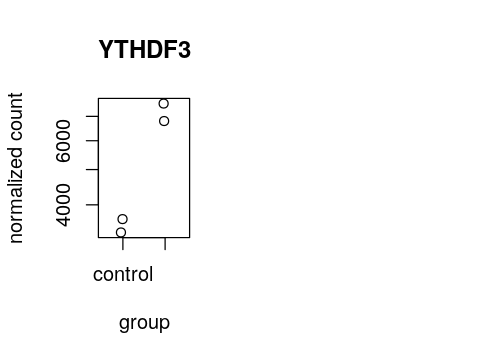

In [16]:
par(mfrow=c(1,2))
plotCounts(dds, gene="SMAD3", normalized = TRUE)  
plotCounts(dds, gene="CCND1", normalized = TRUE)  
plotCounts(dds, gene="YTHDF3", normalized = TRUE)

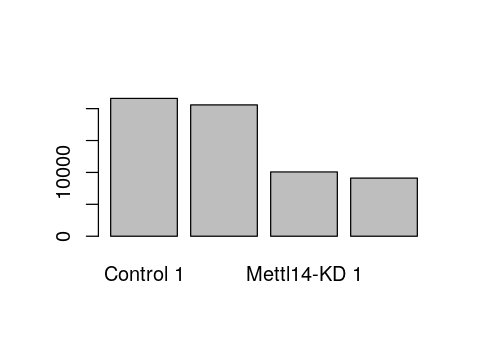

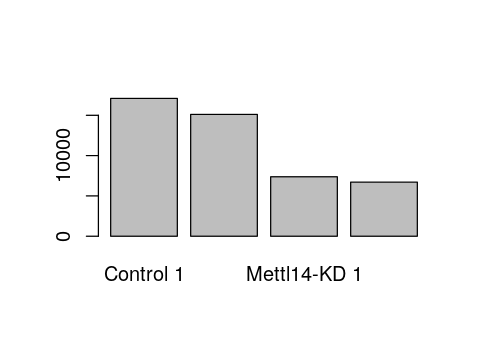

In [20]:
barplot(counts(dds)["SMAD3",])
barplot(counts(dds)["CCND1",])

In [25]:
write.table(res, "deseq.results.tsv", sep="\t", col.names=NA, quote=FALSE)